# Phân tích dữ liệu — Pima Indians Diabetes

Notebook này mô phỏng **quy trình phân tích dữ liệu (EDA → Tiền xử lý → Mô hình hóa → Đánh giá)** theo phong cách bài mẫu Iris. Bạn có thể mở, chạy từng ô (cell) và điều chỉnh tham số theo dữ liệu thực tế.
---


In [12]:
# Imports cơ bản và đọc dữ liệu
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Đặt đường dẫn tới file CSV - chỉnh nếu cần
data_path = r"pima-indians-diabetes.csv"

# Đọc dữ liệu
try:
    df = pd.read_csv(data_path)
    print('Dữ liệu đã được nạp từ:', data_path)
except Exception as e:
    print('Không thể đọc file CSV ở', data_path, '\nLỗi:', e)
    # tạo dataframe mẫu cấu trúc chuẩn nếu file không tồn tại
    cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']
    df = pd.DataFrame(columns=cols)
    print('Đã tạo DataFrame trống với các cột mẫu. Hãy cập nhật data_path nếu cần.')

df.head()

Dữ liệu đã được nạp từ: pima-indians-diabetes.csv


6  148  72  35    0  33.6  0.627  50  1
0  1   85  66  29    0  26.6  0.351  31  0
1  8  183  64   0    0  23.3  0.672  32  1
2  1   89  66  23   94  28.1  0.167  21  0
3  0  137  40  35  168  43.1  2.288  33  1
4  5  116  74   0    0  25.6  0.201  30  0

## 1) Khám phá dữ liệu (EDA)
- Kiểm tra kích thước, kiểu dữ liệu, giá trị thiếu
- Thống kê mô tả và trực quan hóa phân bố


Kích thước dữ liệu: (767, 9)

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6       767 non-null    int64  
 1   148     767 non-null    int64  
 2   72      767 non-null    int64  
 3   35      767 non-null    int64  
 4   0       767 non-null    int64  
 5   33.6    767 non-null    float64
 6   0.627   767 non-null    float64
 7   50      767 non-null    int64  
 8   1       767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Thống kê mô tả:


6         148          72          35           0        33.6  \
count  767.000000  767.000000  767.000000  767.000000  767.000000  767.000000   
mean     3.842243  120.859192   69.101695   20.517601   79.903520   31.990482   
std      3.370877   31.978468   19.368155   15.954059  115.283105    7.889091   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   32.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  127.500000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

            0.627          50           1  
count  767.000000  767.000000  767.000000  
mean     0.471674   33.219035    0.348110  
std      0.331497   11.752296    0.476682  
min      0.078000   21.000000    0.000000  
25%      0.243500   24.000000    0.000000  
50%      0.371000   29.000000    0.000000  
75%      0.625000   41.000000    1.000000  
max      2.420000   81.000000    1.000000


Số giá trị thiếu (NA) mỗi cột:
6        0
148      0
72       0
35       0
0        0
33.6     0
0.627    0
50       0
1        0
dtype: int64


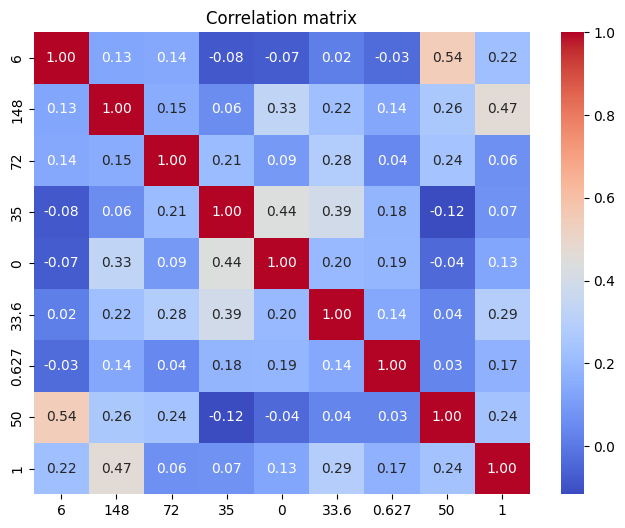

In [13]:
# Thống kê cơ bản
print('Kích thước dữ liệu:', df.shape)
print('\nThông tin dữ liệu:')
print(df.info())
print('\nThống kê mô tả:')
display(df.describe())

# Kiểm tra giá trị missing theo cột
print('\nSố giá trị thiếu (NA) mỗi cột:')
print(df.isna().sum())

# Một số biểu đồ EDA (chạy từng ô nếu gặp vấn đề đồ họa)
if df.shape[0] > 0:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('default')

    # Histogram cho từng biến số
    df.hist(bins=15, figsize=(12,10))
    plt.tight_layout()
    plt.show()

    # Heatmap tương quan
    plt.figure(figsize=(8,6))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation matrix')
    plt.show()

    # Boxplot so sánh phân bố theo Outcome cho một số biến
    vars_to_plot = ['Glucose','BMI','Age','BloodPressure']
    for v in vars_to_plot:
        if v in df.columns:
            plt.figure(figsize=(6,3))
            sns.boxplot(x='Outcome', y=v, data=df)
            plt.title(f'Boxplot {v} by Outcome')
            plt.show()


## 2) Tiền xử lý (Preprocessing)
- Xử lý các giá trị 0 không hợp lệ (Glucose, BloodPressure, BMI, ...)
- Imputation (thay thế giá trị thiếu)
- Chuẩn hóa (StandardScaler)


In [14]:
# Sao chép dataframe để xử lý
df_proc = df.copy()

# Các cột mà giá trị 0 có thể là missing
# Updated column names based on the actual dataframe structure
cols_zero_as_na = ['148', '72', '35', '0', '33.6'] # Corresponds to Glucose, BloodPressure, SkinThickness, Insulin, BMI

for c in cols_zero_as_na:
    if c in df_proc.columns:
        df_proc[c] = df_proc[c].replace(0, np.nan)

print('Số giá trị NA sau khi thay 0->NaN:')
print(df_proc.isna().sum())

# Impute dùng median cho các cột numeric
num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df_proc[num_cols] = imputer.fit_transform(df_proc[num_cols])

# Kiểm tra lại
print('\nSau khi impute:')
print(df_proc.isna().sum())

# Chuẩn hóa thuộc tính (trừ cột Outcome)
# Correctly identify the 'Outcome' column as '1'
X = df_proc.drop(columns=['1']) if '1' in df_proc.columns else df_proc.copy()
y = df_proc['1'] if '1' in df_proc.columns else pd.Series([], dtype=int)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) if X.shape[0] > 0 else X
X = pd.DataFrame(X_scaled, columns=X.columns)

print('\nHoàn tất tiền xử lý. Kích thước X, y:', X.shape, getattr(y, 'shape', None))

Số giá trị NA sau khi thay 0->NaN:
6          0
148        5
72        35
35       227
0        373
33.6      11
0.627      0
50         0
1          0
dtype: int64

Sau khi impute:
6        0
148      0
72       0
35       0
0        0
33.6     0
0.627    0
50       0
1        0
dtype: int64

Hoàn tất tiền xử lý. Kích thước X, y: (767, 8) (767,)


## 3) Mô hình hóa (Modeling)
- Chia train/test
- Huấn luyện Logistic Regression, Decision Tree, Random Forest, SVM
- Đánh giá bằng Accuracy, Precision, Recall, F1


In [15]:
# Nếu dữ liệu rỗng thì dừng
if X.shape[0] == 0:
    print('Dataset rỗng — vui lòng cập nhật đường dẫn tới file CSV thực tế và chạy lại.')
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y if y.nunique()>1 else None)
    models = {
        'LogisticRegression': LogisticRegression(max_iter=200),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        results.append((name, acc, prec, rec, f1))
        print(f'----- {name} -----')
        print(classification_report(y_test, y_pred, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        print('Confusion matrix:\n', cm)
        print('\n')

    res_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1'])
    display(res_df.sort_values('Accuracy', ascending=False))

----- LogisticRegression -----
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       151
         1.0       0.62      0.49      0.55        80

    accuracy                           0.72       231
   macro avg       0.69      0.66      0.67       231
weighted avg       0.71      0.72      0.71       231

Confusion matrix:
 [[127  24]
 [ 41  39]]


----- DecisionTree -----
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75       151
         1.0       0.52      0.50      0.51        80

    accuracy                           0.67       231
   macro avg       0.63      0.63      0.63       231
weighted avg       0.66      0.67      0.67       231

Confusion matrix:
 [[114  37]
 [ 40  40]]


----- RandomForest -----
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       151
         1.0       0.67      0.57      0.62        80

    accuracy 

Model  Accuracy  Precision  Recall        F1
2        RandomForest  0.753247   0.666667  0.5750  0.617450
3                 SVM  0.731602   0.666667  0.4500  0.537313
0  LogisticRegression  0.718615   0.619048  0.4875  0.545455
1        DecisionTree  0.666667   0.519481  0.5000  0.509554

## 4) Kết luận & Gợi ý
- Xem cột `res_df` để chọn mô hình tốt nhất.
- Kiểm tra biến quan trọng từ RandomForest để hiểu yếu tố ảnh hưởng.
- Nếu cần deploy: lưu model bằng joblib/pickle và tích hợp vào ứng dụng.


In [16]:
# Nếu có RandomForest, hiển thị feature importances
if 'RandomForest' in models and X.shape[0] > 0:
    rf = models['RandomForest']
    if hasattr(rf, 'feature_importances_'):
        fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        print('Feature importances (RandomForest):')
        display(fi)


Feature importances (RandomForest):


148      0.267290
33.6     0.157192
50       0.121206
0.627    0.108551
6        0.097178
72       0.090510
0        0.085378
35       0.072696
dtype: float64